In [1]:
!pip install folium

In [2]:
#Common libraries
import pandas as pd
import numpy as np
import os
import re
import locale
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import seaborn as sns
import tkinter as tk
import folium
from folium import plugins

#Library to access sql database
import sqlite3

#Library for model development
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV

#Library for ignoring warning
import warnings
warnings.filterwarnings('ignore')



In [3]:
#In first dataset, since the data has default index, I need to remove the index prior to pre-processing
df= pd.read_excel("rumah123-LL.xlsx").reset_index(drop=True)


prepocessing


In [4]:


print('Info about data:')
print(df.info())
print('\nShape about data:')
print(df.shape)
df.head()

Info about data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678 entries, 0 to 677
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type properti  678 non-null    object 
 1   Harga (juta)   678 non-null    int64  
 2   Lokasi         678 non-null    object 
 3   KM             647 non-null    float64
 4   KT             644 non-null    float64
 5   GARASI         459 non-null    float64
 6   LT             678 non-null    int64  
 7   LB:            678 non-null    int64  
 8   Latitude       678 non-null    float64
 9   Longitude      678 non-null    float64
dtypes: float64(5), int64(3), object(2)
memory usage: 53.1+ KB
None

Shape about data:
(678, 10)


,Type properti,Harga (juta),Lokasi,KM,KT,GARASI,LT,LB:,Latitude,Longitude
0,Rumah,685000000,"Bukit Raya, Pekanbaru",2.0,3.0,2.0,120,70,0.467153,101.471542
1,Rumah,500000000,"Senapelan, Pekanbaru",1.0,1.0,NaN,122,96,0.539333,101.437029
2,Rumah,2680000000,"Bukit Raya, Pekanbaru",3.0,3.0,1.0,189,148,0.467153,101.471542
3,Rumah,5380000000,"Bukit Raya, Pekanbaru",4.0,4.0,2.0,300,315,0.467153,101.471542
4,Rumah,3800000000,"Bukit Raya, Pekanbaru",4.0,5.0,2.0,225,198,0.467153,101.471542


In [5]:


df['Harga'] = df['Harga (juta)'] / 1000000
df = df.drop(columns=['Harga (juta)'])

print("Info data setelah perubahan kolom Harga:")
print(df.info())
print("\nLima baris pertama data setelah perubahan kolom Harga:")
display(df.head())



Info data setelah perubahan kolom Harga:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678 entries, 0 to 677
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type properti  678 non-null    object 
 1   Lokasi         678 non-null    object 
 2   KM             647 non-null    float64
 3   KT             644 non-null    float64
 4   GARASI         459 non-null    float64
 5   LT             678 non-null    int64  
 6   LB:            678 non-null    int64  
 7   Latitude       678 non-null    float64
 8   Longitude      678 non-null    float64
 9   Harga          678 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 53.1+ KB
None

Lima baris pertama data setelah perubahan kolom Harga:


,Type properti,Lokasi,KM,KT,GARASI,LT,LB:,Latitude,Longitude,Harga
0,Rumah,"Bukit Raya, Pekanbaru",2.0,3.0,2.0,120,70,0.467153,101.471542,685.0
1,Rumah,"Senapelan, Pekanbaru",1.0,1.0,NaN,122,96,0.539333,101.437029,500.0
2,Rumah,"Bukit Raya, Pekanbaru",3.0,3.0,1.0,189,148,0.467153,101.471542,2680.0
3,Rumah,"Bukit Raya, Pekanbaru",4.0,4.0,2.0,300,315,0.467153,101.471542,5380.0
4,Rumah,"Bukit Raya, Pekanbaru",4.0,5.0,2.0,225,198,0.467153,101.471542,3800.0


feature and target corelation


<Figure size 1200x600 with 0 Axes>

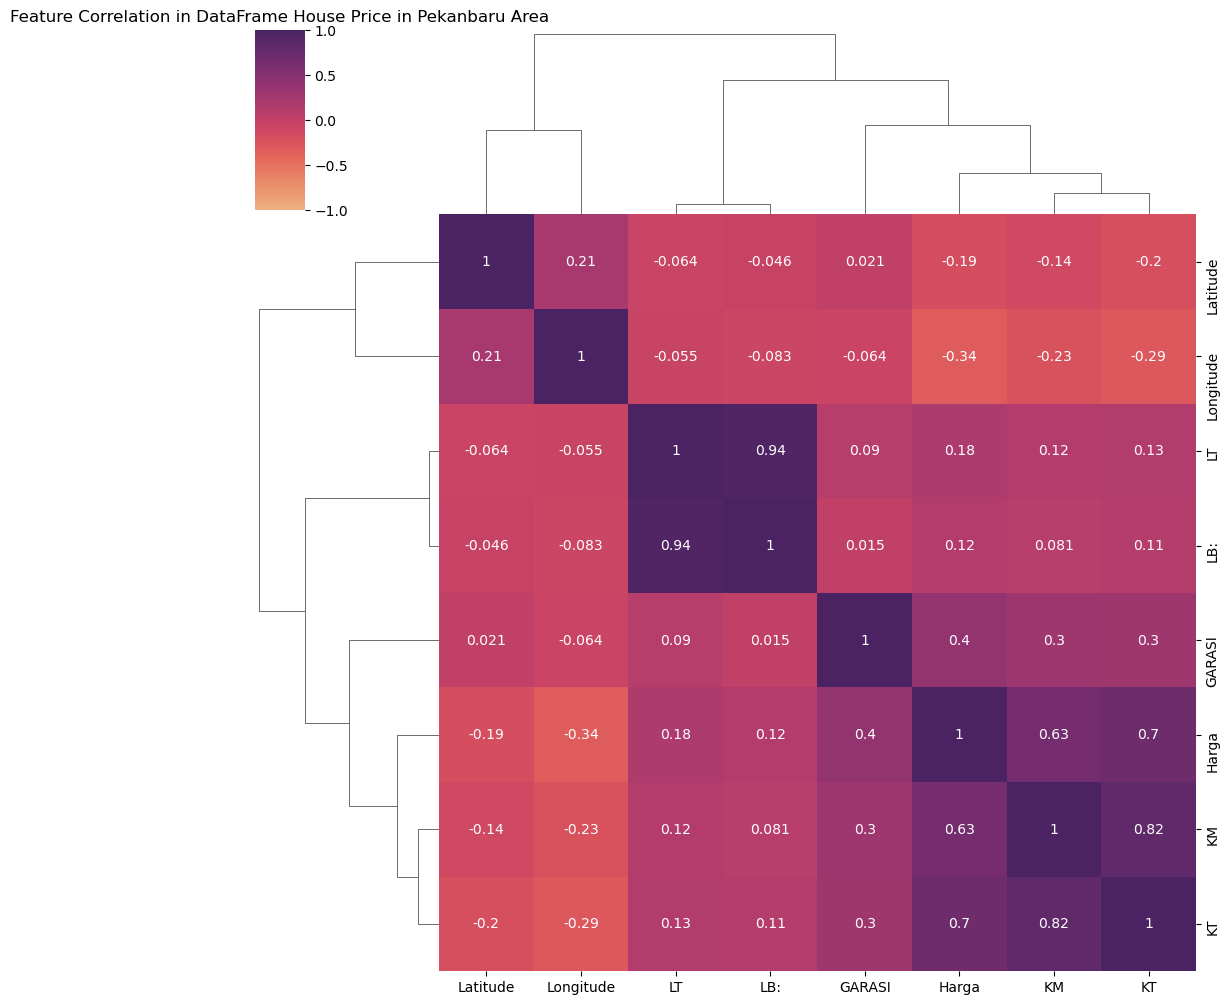

In [6]:


plt.figure(figsize=(12, 6))
sns.clustermap(df.corr(method='pearson', numeric_only=True),
               vmin = -1.0,
               vmax = 1.0,
               cmap = 'flare',
               method = 'complete',
               annot = True)

plt.title('Feature Correlation in DataFrame House Price in Pekanbaru Area')
plt.show()



- fitur LT dan LB memiliki hubungan yang sangat kuat.
- fitur Harga dengan kamar tidur(0,7), harga dengan kamar mandi(0,63), kamar mandi dan kamar tidur (0.82) memiliki hubungan yang kuat
- Harga dengan KT (0.7) dan Harga dengan KM (0.63)
Korelasi kuat dengan target itu justru bagus berarti fitur ini penting untuk prediksi harga.

pada correlation plot diatas, dapat kita lihat bahwa LT dan LB memiliki hubungan yang sangat kuat (0.94). dari informasi diatas, kita perlu melakukan pembersihan data dengan melakukan removing outlier berdasarkan harga tanah per m2 dan harga bangunan per m2,  IQR dihitung secara terpisah berdasarkan Lokasi karena dalam proyek ini perhitungan model harga akan dipisahkan untuk setiap lokasi

In [7]:


# --- 1. Buat fitur turunan harga per m2 ---
df['Harga_per_m2_Tanah'] = df['Harga'] / df['LT']
df['Harga_per_m2_Bangunan'] = df['Harga'] / df['LB:']

areas = df['Lokasi'].unique()
lists = ['Harga_per_m2_Tanah', 'Harga_per_m2_Bangunan']
index_outlier = []

for i in areas:
    print('For Area:', i, "\n")
    df_rg = df[df['Lokasi'] == i]
    for j in lists:
        quartile_1 = df_rg[j].quantile(0.25)
        quartile_3 = df_rg[j].quantile(0.75)
        IQR = quartile_3 - quartile_1
        print('For column',j)
        up_bound = quartile_3 + IQR*1.5
        lo_bound = quartile_1 - IQR*1.5
        print('Upper bound is', up_bound)
        index_outlier.extend(df_rg[df_rg[j] > up_bound].index.tolist())
        print('Lower bound is', lo_bound)
        index_outlier.extend(df_rg[df_rg[j] < lo_bound].index.tolist())
        print(" ")

df_sorted = df.drop(index_outlier)

For Area: Bukit Raya, Pekanbaru 

For column Harga_per_m2_Tanah
Upper bound is 15.93528911564626
Lower bound is -4.454506802721089
 
For column Harga_per_m2_Bangunan
Upper bound is 19.703739306516198
Lower bound is -2.8558256734619585
 
For Area: Senapelan, Pekanbaru 

For column Harga_per_m2_Tanah
Upper bound is 8.22111154560563
Lower bound is -1.5021351949448536
 
For column Harga_per_m2_Bangunan
Upper bound is 20.52025991792066
Lower bound is -7.925923392612862
 
For Area: Marpoyan Damai, Pekanbaru 

For column Harga_per_m2_Tanah
Upper bound is 21.491032340609195
Lower bound is -6.954552811690712
 
For column Harga_per_m2_Bangunan
Upper bound is 23.645833333333336
Lower bound is -1.8541666666666687
 
For Area: Rumbai, Pekanbaru 

For column Harga_per_m2_Tanah
Upper bound is 14.422983409610982
Lower bound is -4.652340770404271
 
For column Harga_per_m2_Bangunan
Upper bound is 18.369587283425957
Lower bound is -1.0011809414841446
 
For Area: Tampan, Pekanbaru 

For column Harga_per_m2

Sekarang, setelah menghapus outlier mari kita lihat plot korelasi yang baru. Dengan menghapus outlier, korelasi antara 'LT' dan 'LB' dengan 'harga' sedikit membaik.


<Figure size 1200x600 with 0 Axes>

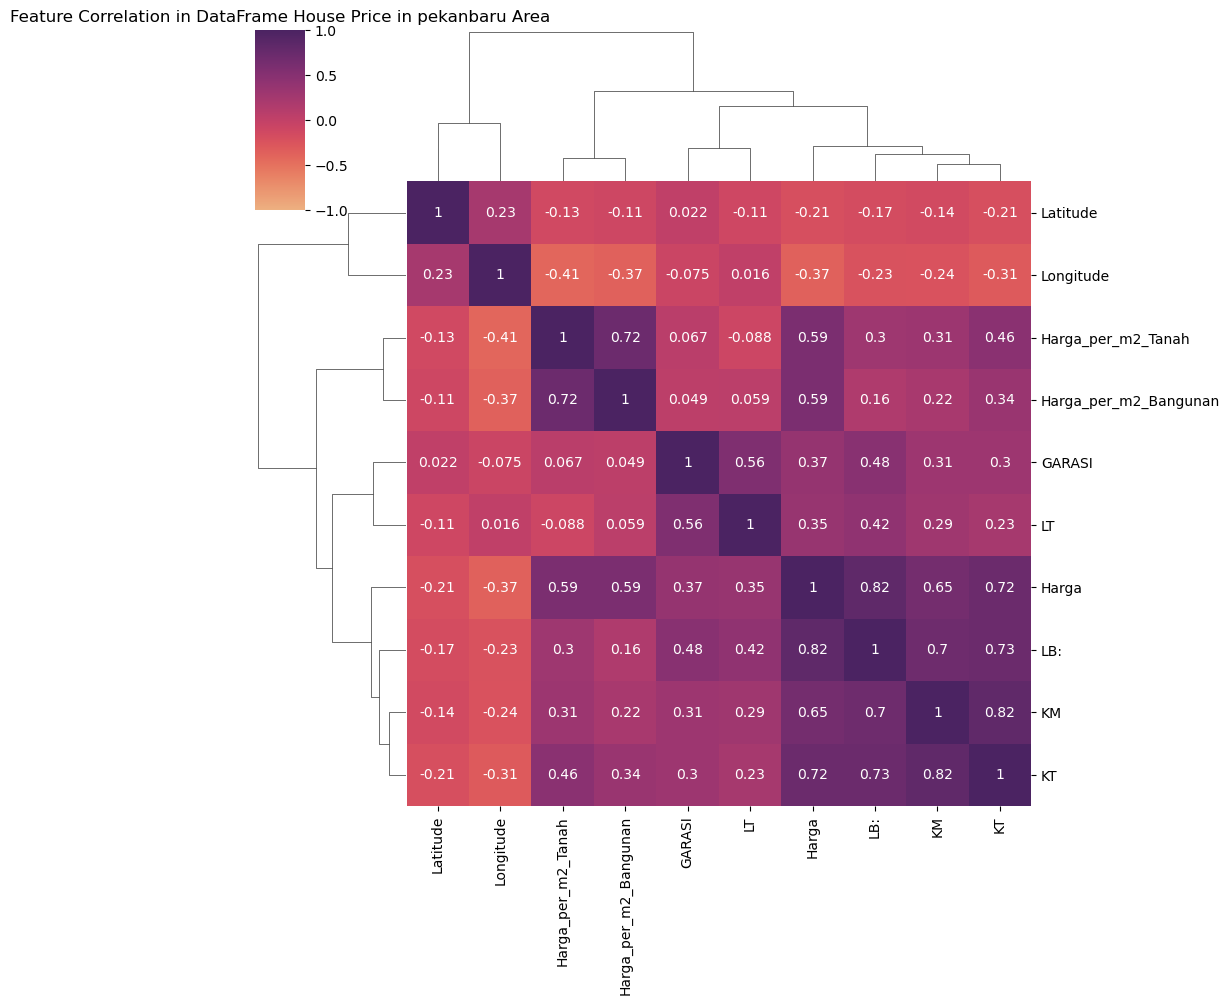

In [8]:


plt.figure(figsize=(12, 6))
sns.clustermap(df_sorted.corr(method='pearson', numeric_only=True),
               vmin = -1.0,
               vmax = 1.0,
               cmap = 'flare',
               method = 'complete',
               annot = True)

plt.title('Feature Correlation in DataFrame House Price in pekanbaru Area')
plt.show()



Sekarang, setelah menghapus outlier mari kita lihat plot korelasi yang baru. Dengan menghapus outlier, korelasi antara 'LT' dan 'LB' dengan 'harga' sedikit membaik. Mari kita bandingkan secara lebih detail:

*   **Sebelum Menghapus Outlier (Plot Pertama)**: Lihat kembali korelasi antara `LT` dan `Harga(juta)`, serta `LB:` dan `Harga(juta)`.
*   **Setelah Menghapus Outlier (Plot Kedua)**: Lihat korelasi yang sama pada plot korelasi yang baru.

nilai korelasi (angka di dalam kotak) untuk pasangan fitur `LT` - `Harga(juta)` dan `LB:` - `Harga(juta)` pada plot kedua sedikit lebih tinggi (lebih dekat ke 1) dibandingkan dengan plot pertama. Ini menunjukkan bahwa hubungan linear antara luas properti dan harga menjadi sedikit lebih jelas setelah nilai-nilai ekstrem (outlier) yang mungkin mengaburkan hubungan tersebut dihilangkan.

Jadi, **ya, feature correlation kedua mengalami perbaikan** dalam arti bahwa korelasi antara fitur luas tanah/bangunan dan harga properti menjadi sedikit lebih kuat dan merepresentasikan hubungan yang lebih baik setelah data dibersihkan dari outlier.

In [9]:


#missing value
print("Jumlah nilai yang hilang sebelum penanganan:")
print(df_sorted[['KM', 'KT', 'GARASI']].isnull().sum())

# Buat salinan agar tidak mengubah df_sorted asli
df_cleaned = df_sorted.copy()

# Jika KT tidak ada nilai (NaN), hapus baris tersebut
df_cleaned.dropna(subset=['KT'], inplace=True)

# Isi nilai yang hilang di GARASI dengan 1
df_cleaned['GARASI'].fillna(1, inplace=True)

# Isi nilai yang hilang di KM dengan 1 (setelah baris dengan KT NaN dihapus)
df_cleaned['KM'].fillna(1, inplace=True)


print("\nJumlah nilai yang hilang setelah penanganan:")
print(df_cleaned[['KM', 'KT', 'GARASI']].isnull().sum())

print("\nInfo data setelah penanganan nilai hilang:")
print(df_cleaned.info())



Jumlah nilai yang hilang sebelum penanganan:
KM         30
KT         33
GARASI    209
dtype: int64

Jumlah nilai yang hilang setelah penanganan:
KM        0
KT        0
GARASI    0
dtype: int64

Info data setelah penanganan nilai hilang:
<class 'pandas.core.frame.DataFrame'>
Index: 618 entries, 0 to 677
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Type properti          618 non-null    object 
 1   Lokasi                 618 non-null    object 
 2   KM                     618 non-null    float64
 3   KT                     618 non-null    float64
 4   GARASI                 618 non-null    float64
 5   LT                     618 non-null    int64  
 6   LB:                    618 non-null    int64  
 7   Latitude               618 non-null    float64
 8   Longitude              618 non-null    float64
 9   Harga                  618 non-null    float64
 10  Harga_per_m2_Tanah     618 non-n

In [10]:
df_cleaned

,Type properti,Lokasi,KM,KT,GARASI,LT,LB:,Latitude,Longitude,Harga,Harga_per_m2_Tanah,Harga_per_m2_Bangunan
0,Rumah,"Bukit Raya, Pekanbaru",2.0,3.0,2.0,120,70,0.467153,101.471542,685.0,5.708333,9.785714
1,Rumah,"Senapelan, Pekanbaru",1.0,1.0,1.0,122,96,0.539333,101.437029,500.0,4.098361,5.208333
2,Rumah,"Bukit Raya, Pekanbaru",3.0,3.0,1.0,189,148,0.467153,101.471542,2680.0,14.179894,18.108108
5,Rumah,"Bukit Raya, Pekanbaru",2.0,3.0,1.0,150,75,0.467153,101.471542,695.0,4.633333,9.266667
6,Rumah,"Marpoyan Damai, Pekanbaru",3.0,3.0,2.0,116,148,0.526246,101.451573,2200.0,18.965517,14.864865
...,...,...,...,...,...,...,...,...,...,...,...,...
672,Rumah,"Tampan, Pekanbaru",4.0,5.0,1.0,500,300,0.495049,101.384299,5150.0,10.300000,17.166667
673,Rumah,"Tampan, Pekanbaru",6.0,5.0,1.0,500,400,0.495049,101.384299,5950.0,11.900000,14.875000
674,Rumah,"Tampan, Pekanbaru",2.0,2.0,1.0,150,58,0.495049,101.384299,450.0,3.000000,7.758621
675,Rumah,"Payung Sekaki, Pekanbaru",4.0,3.0,1.0,211,162,0.526246,101.451573,1800.0,8.530806,11.111111


Setelah melakukan pembersihan outlier dan analisis korelasi, langkah-langkah selanjutnya yang perlu dilakukan untuk melanjutkan proyek analisis dan pemodelan harga properti adalah:

1.  **Penanganan Nilai yang Hilang (Missing Values)**: Mengatasi nilai-nilai yang kosong pada kolom seperti `KM`, `KT`, dan `GARASI`.
2.  **Encoding Variabel Kategorikal**: Mengubah kolom `Type properti` dan `Lokasi` menjadi format numerik agar bisa digunakan dalam model.
3.  **Pemilihan Fitur (Feature Selection)**: Memilih fitur-fitur yang paling relevan untuk memprediksi harga.
4.  **Skalasi Fitur (Feature Scaling)**: Menyesuaikan skala fitur numerik agar seragam.
5.  **Membangun Model Machine Learning**: Melatih model untuk memprediksi harga properti.
6.  **Evaluasi Model**: Mengukur seberapa baik performa model.


In [11]:
# Encoding Variabel Kategorikal
df_encoded = pd.get_dummies(df_cleaned, columns=['Type properti', 'Lokasi'])

print("\nInfo data setelah encoding:")
print(df_encoded.info())
print("\nLima baris pertama data setelah encoding:")
display(df_encoded.head())




Info data setelah encoding:
<class 'pandas.core.frame.DataFrame'>
Index: 618 entries, 0 to 677
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   KM                                618 non-null    float64
 1   KT                                618 non-null    float64
 2   GARASI                            618 non-null    float64
 3   LT                                618 non-null    int64  
 4   LB:                               618 non-null    int64  
 5   Latitude                          618 non-null    float64
 6   Longitude                         618 non-null    float64
 7   Harga                             618 non-null    float64
 8   Harga_per_m2_Tanah                618 non-null    float64
 9   Harga_per_m2_Bangunan             618 non-null    float64
 10  Type properti_Rumah               618 non-null    bool   
 11  Lokasi_Bukit Raya, Pekanbaru      618 non-null 

,KM,KT,GARASI,LT,LB:,Latitude,Longitude,Harga,Harga_per_m2_Tanah,Harga_per_m2_Bangunan,...,"Lokasi_Lima Puluh, Pekanbaru","Lokasi_Marpoyan Damai, Pekanbaru","Lokasi_Payung Sekaki, Pekanbaru","Lokasi_Pekanbaru Kota, Pekanbaru","Lokasi_Rumbai, Pekanbaru","Lokasi_Sail, Pekanbaru","Lokasi_Senapelan, Pekanbaru","Lokasi_Sukajadi, Pekanbaru","Lokasi_Tampan, Pekanbaru","Lokasi_Tenayan Raya, Pekanbaru"
0,2.0,3.0,2.0,120,70,0.467153,101.471542,685.0,5.708333,9.785714,...,False,False,False,False,False,False,False,False,False,False
1,1.0,1.0,1.0,122,96,0.539333,101.437029,500.0,4.098361,5.208333,...,False,False,False,False,False,False,True,False,False,False
2,3.0,3.0,1.0,189,148,0.467153,101.471542,2680.0,14.179894,18.108108,...,False,False,False,False,False,False,False,False,False,False
5,2.0,3.0,1.0,150,75,0.467153,101.471542,695.0,4.633333,9.266667,...,False,False,False,False,False,False,False,False,False,False
6,3.0,3.0,2.0,116,148,0.526246,101.451573,2200.0,18.965517,14.864865,...,False,True,False,False,False,False,False,False,False,False


In [12]:
df['Lokasi'].value_counts()


Lokasi
Tampan, Pekanbaru            240
Marpoyan Damai, Pekanbaru    104
Bukit Raya, Pekanbaru         82
Pekanbaru Kota, Pekanbaru     71
Payung Sekaki, Pekanbaru      63
Tenayan Raya, Pekanbaru       39
Rumbai, Pekanbaru             30
Lima Puluh, Pekanbaru         18
Senapelan, Pekanbaru          12
Sukajadi, Pekanbaru           11
Sail, Pekanbaru                8
Name: count, dtype: int64

Model Development


In [13]:
df_enc = df_encoded.drop(['Latitude', 'Longitude','Type properti_Rumah'], axis=1)
df_enc = df_enc.drop_duplicates()
df_enc = df_enc.reset_index(drop=True)

missing_value = df_enc.isnull()

for col in missing_value.columns.values.tolist():
    print(missing_value[col].value_counts())
    print('')

    

KM
False    608
Name: count, dtype: int64

KT
False    608
Name: count, dtype: int64

GARASI
False    608
Name: count, dtype: int64

LT
False    608
Name: count, dtype: int64

LB:
False    608
Name: count, dtype: int64

Harga
False    608
Name: count, dtype: int64

Harga_per_m2_Tanah
False    608
Name: count, dtype: int64

Harga_per_m2_Bangunan
False    608
Name: count, dtype: int64

Lokasi_Bukit Raya, Pekanbaru
False    608
Name: count, dtype: int64

Lokasi_Lima Puluh, Pekanbaru
False    608
Name: count, dtype: int64

Lokasi_Marpoyan Damai, Pekanbaru
False    608
Name: count, dtype: int64

Lokasi_Payung Sekaki, Pekanbaru
False    608
Name: count, dtype: int64

Lokasi_Pekanbaru Kota, Pekanbaru
False    608
Name: count, dtype: int64

Lokasi_Rumbai, Pekanbaru
False    608
Name: count, dtype: int64

Lokasi_Sail, Pekanbaru
False    608
Name: count, dtype: int64

Lokasi_Senapelan, Pekanbaru
False    608
Name: count, dtype: int64

Lokasi_Sukajadi, Pekanbaru
False    608
Name: count, dtype: i

In [14]:


#Set feature and target variables
X = df_enc.drop('Harga', axis=1)
y = df_enc['Harga']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

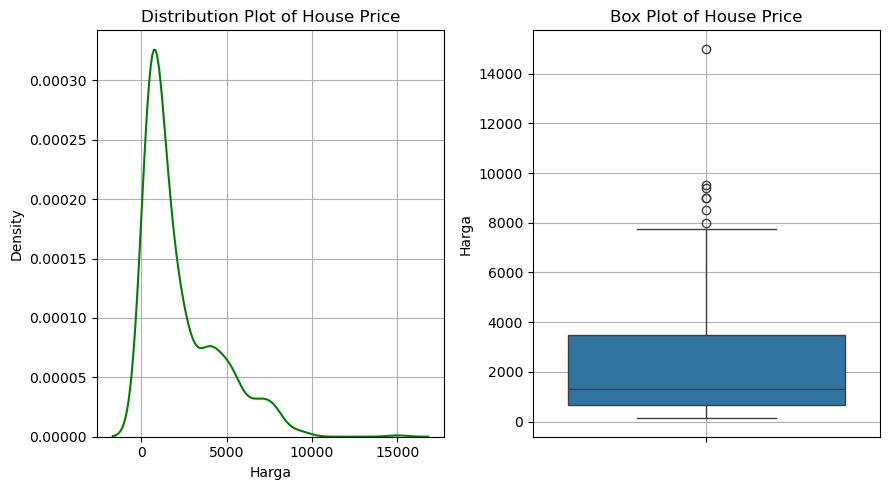

In [15]:


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))

sns.kdeplot(y, color='green', ax=axes[0])
axes[0].set_title('Distribution Plot of House Price')
axes[0].grid()

sns.boxplot(y, ax=axes[1])
axes[1].set_title('Box Plot of House Price')
axes[1].grid()

plt.tight_layout()
plt.show()

In [16]:


# Using StandardScaler for standardize value of target
scaler = MinMaxScaler()
scaler.fit(y_train.values.reshape(-1, 1))
y_train_scaled = scaler.transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))



In [17]:
# Defining initial model
rf = RandomForestRegressor(random_state=42)

In [18]:

# Define the parameter grid for for Random Forest
from sklearn.metrics import r2_score, mean_absolute_error
param_grid = {
    'n_estimators': [1500, 2000, 2500],
    'max_depth': [9, 18, 27],
    'min_samples_split': [2, 4, 6]
}

# Create a GridSearchCV object for Random Forest
rf_cv = GridSearchCV(rf, param_grid, cv=5, n_jobs = 2, verbose = 1, scoring='neg_mean_squared_error')

# Fit the grid search
rf_cv.fit(X_train, y_train_scaled)

# Get the best model and predictions
best_rf = rf_cv.best_estimator_
best_rf_pred = best_rf.predict(X_test)
best_rf_mse = mean_squared_error(y_test_scaled, best_rf_pred)
best_rf_r2   = r2_score(y_test_scaled, best_rf_pred)            # Getting the R-squared (R²)
best_rf_mae  = mean_absolute_error(y_test_scaled, best_rf_pred) # Getting the Mean Absolute Error  # Getting the Mean Squared Error
best_rf_rmse = np.sqrt(best_rf_mse)                       # Getting the Root Mean Squared Error

print('Best Random Forest R2:', best_rf_r2)
print('Best Random Forest MSE:', best_rf_mse)
print('Best Random Forest MAE:', best_rf_mae)
print('Best Random Forest RMSE:', best_rf_rmse)
print(best_rf)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

Best Random Forest R2: 0.9540370232460741
Best Random Forest MSE: 0.0009363515970577884
Best Random Forest MAE: 0.008708989718946215
Best Random Forest RMSE: 0.030599862696714643
RandomForestRegressor(max_depth=18, n_estimators=2000, random_state=42)


In [25]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test) 

from sklearn.ensemble import RandomForestRegressor 
model = RandomForestRegressor( 
    max_depth=9,  
    n_estimators=2500, 
    random_state=42 ) 

model.fit(X_train_scaled, y_train) # y_train TIDAK di-scale 

import numpy as np # Data baru harus sesuai urutan 
X_train.columns 
new_data = np.array([[3, 2, 1, 150, 75, 4.6, 9.2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) 

new_data_scaled = scaler.transform(new_data) # Prediksi langsung — TANPA inverse 
predicted_price = model.predict(new_data_scaled) 

print(f"Prediksi Harga Rumah: {predicted_price[0]:,.2f} juta")

Prediksi Harga Rumah: 684.88 juta


Saya telah menggunakan lima model regresi—empat regressor terpisah dan satu stacking regressor—untuk memprediksi variabel target. Plot distribusi digunakan untuk mengevaluasi sebaran prediksi mereka dan memahami seberapa baik kinerja masing-masing model. Berikut adalah plot distribusinya:


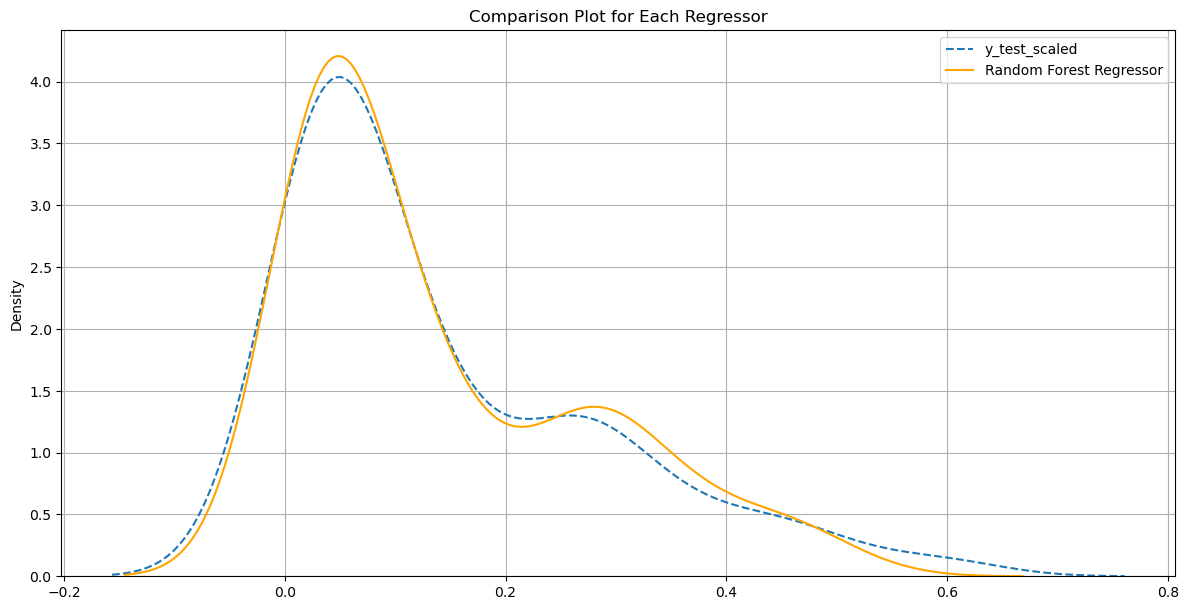

In [26]:
plt.figure(figsize=(12, 6))

# Plot distributions for each regressors
sns.kdeplot(y_test_scaled, color='green', linestyle='dashed', ax=plt.gca(), label='y_test_scaled')
sns.kdeplot(best_rf_pred, color='orange', ax=plt.gca(), label='Random Forest Regressor')

plt.tight_layout()
plt.title('Comparison Plot for Each Regressor')
plt.legend(loc='upper right')
plt.grid()
plt.show()

#user friendly input function

In [30]:
import tkinter as tk
from tkinter import ttk
import numpy as np

# ======================
# Lokasi Sesuai Kolom Model
# ======================
lokasi_cols = [
    'Lokasi_Lima Puluh, Pekanbaru',
    'Lokasi_Marpoyan Damai, Pekanbaru',
    'Lokasi_Payung Sekaki, Pekanbaru',
    'Lokasi_Pekanbaru Kota, Pekanbaru',
    'Lokasi_Rumbai, Pekanbaru',
    'Lokasi_Sail, Pekanbaru',
    'Lokasi_Senapelan, Pekanbaru',
    'Lokasi_Bukit Raya, Pekanbaru',
    'Lokasi_Sukajadi, Pekanbaru',
    'Lokasi_Tampan, Pekanbaru',
    'Lokasi_Tenayan Raya, Pekanbaru'
]

# ===================================================
# Fungsi Prediksi
# ===================================================
def predict_price():
    try:
        KM = float(entry_km.get())
        KT = float(entry_kt.get())
        GARASI = float(entry_garasi.get())
        LT = float(entry_lt.get())
        LB = float(entry_lb.get())

        lokasi = lokasi_var.get()

        # One-hot lokasi
        lokasi_vector = [1 if loc == lokasi else 0 for loc in lokasi_cols]

        # Input sesuai urutan X_train
        input_data = np.array([[
            KM, KT, GARASI, LT, LB,
            0,     # Harga_per_m2_Tanah (default)
            0,     # Harga_per_m2_Bangunan (default)
            *lokasi_vector
        ]])

        # Scale X
        input_scaled = scaler.transform(input_data)

        # Prediksi dalam satuan JUTA
        predicted_price = model.predict(input_scaled)[0]

        hasil_rupiah = predicted_price * 1_000_000

        result_label.config(
            text=f"Prediksi Harga Rumah: Rp {hasil_rupiah:,.0f}"
        )

    except Exception as e:
        result_label.config(text="Error: " + str(e))


# ===================================================
# GUI TKINTER
# ===================================================
root = tk.Tk()
root.title("Prediksi Harga Rumah Pekanbaru")
root.geometry("450x600")
root.resizable(False, False)

# Judul
title_label = tk.Label(root, text="Prediksi Harga Rumah", font=("Arial", 16, "bold"))
title_label.pack(pady=10)

frame = tk.Frame(root)
frame.pack(pady=10)

# Input KM
tk.Label(frame, text="KM (Kamar Mandi):").grid(row=0, column=0, sticky="w")
entry_km = tk.Entry(frame)
entry_km.grid(row=0, column=1)

# Input KT
tk.Label(frame, text="KT (Kamar Tidur):").grid(row=1, column=0, sticky="w")
entry_kt = tk.Entry(frame)
entry_kt.grid(row=1, column=1)

# Input Garasi
tk.Label(frame, text="Garasi:").grid(row=2, column=0, sticky="w")
entry_garasi = tk.Entry(frame)
entry_garasi.grid(row=2, column=1)

# Input LT
tk.Label(frame, text="Luas Tanah (m2):").grid(row=3, column=0, sticky="w")
entry_lt = tk.Entry(frame)
entry_lt.grid(row=3, column=1)

# Input LB
tk.Label(frame, text="Luas Bangunan (m2):").grid(row=4, column=0, sticky="w")
entry_lb = tk.Entry(frame)
entry_lb.grid(row=4, column=1)

# Dropdown Lokasi
tk.Label(frame, text="Lokasi:").grid(row=5, column=0, sticky="w")
lokasi_var = tk.StringVar()
lokasi_dropdown = ttk.Combobox(frame, textvariable=lokasi_var, values=lokasi_cols, width=30)
lokasi_dropdown.grid(row=5, column=1)
lokasi_dropdown.current(0)

# Tombol Prediksi
predict_button = tk.Button(root, text="Prediksi Harga", command=predict_price,
                           font=("Arial", 12), bg="#4CAF50", fg="white")
predict_button.pack(pady=20)

# Output Hasil
result_label = tk.Label(root, text="", font=("Arial", 12))
result_label.pack(pady=10)

root.mainloop()
